# Задание

1) Натренировать нейронную сеть, отличающую классы bicycle, motorcycle, background (всё, что не велосипед и не мотоцикл). (6 баллов)
    * Можно использовать претренированную модель, но нужно ее дообучить.
    * Не должно быть багов (обратите внимание на дисбаланс классов).
2) Провести анализ результатов (confusion матрица, зависимость точности от внешних условий, сравнение моделей, анализ метрик, ...). (1-2 балла в зависимости от полноты анализа)
3) Сравнить производительность в разных рантаймах: onnxruntime, tensorrt, tvm, tflite, pytorch-keras, openvino... (0.5 балла за каждый фреймворк)
4) Продемонстрировать манипуляцию весами: трансформировать первый слой, чтобы количество входных каналов в первой свертке было не 3, а 1 с минимальной потерей точности. То есть, сетка должна работать на грейскейле. (1 балл)

## Настройки/Гиперпараметры/Импорты

In [1]:
import torchvision # для работы (скачивания, преобразования...) с картинками (датасетом)
import torch # для работы с тензорами и моделями
from transformers import ViTForImageClassification, ViTImageProcessor # для предобученной модели и трансформера данных
# transformers version 4.35.2

import numpy as np # для работы с матрицами

import pickle # для сохранения файлов
import random # для изменения пропорции данных в обучающем датасете (классы "background" будут случайно заменяться на классы "bicycle" и "motorcycle")
from tqdm import tqdm # для отслеживания прогресса выполнения

import matplotlib.pyplot as plt # для вывода графиков/картинок
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # для оценивания качества предсказаний модели

In [2]:
dtype = torch.float64 # используемый тип данных
device = torch.device("cuda") # устройство, на котором будет работать модель

models_path = "./models/" # путь, куда будут сохраняться модели (из state_dict)
# models_path = "/content/drive/MyDrive/tmp/lab3/models/"
data_path = "./data/"
# data_path = "/content/drive/MyDrive/tmp/lab3/data/"
loss_path = "./losses/"
# loss_path = "/content/drive/MyDrive/tmp/lab3/losses/"

num_classes = 3 # число классов (в задании: bicycle, motorcycle, background)
epochs = 5 # число эпох обучения
learning_rate = 0.0001 # скорость обучения модели

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка датасета и модели

## Датасет

CIFAR-100 — датасет, состоящий из 60 000 изображений, поделенных на 100 классов. В обучающей выборке присутствуют 50 000 изображений, по 500 сэмплов для каждого класса. Тогда как в тестовой — 10 000 по 100 сэмплов.

Каждое изображение имеет размерность (3, 32, 32) ~ (Channels, Height, Width).

Классы (labels) датасета:


In [ ]:
classes = ["apple",  "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]
for i in range (len(classes)):
    print(f"Класс {i}: {classes[i]}")

Класс 0: apple
Класс 1: aquarium_fish
Класс 2: baby
Класс 3: bear
Класс 4: beaver
Класс 5: bed
Класс 6: bee
Класс 7: beetle
Класс 8: bicycle
Класс 9: bottle
Класс 10: bowl
Класс 11: boy
Класс 12: bridge
Класс 13: bus
Класс 14: butterfly
Класс 15: camel
Класс 16: can
Класс 17: castle
Класс 18: caterpillar
Класс 19: cattle
Класс 20: chair
Класс 21: chimpanzee
Класс 22: clock
Класс 23: cloud
Класс 24: cockroach
Класс 25: couch
Класс 26: crab
Класс 27: crocodile
Класс 28: cup
Класс 29: dinosaur
Класс 30: dolphin
Класс 31: elephant
Класс 32: flatfish
Класс 33: forest
Класс 34: fox
Класс 35: girl
Класс 36: hamster
Класс 37: house
Класс 38: kangaroo
Класс 39: keyboard
Класс 40: lamp
Класс 41: lawn_mower
Класс 42: leopard
Класс 43: lion
Класс 44: lizard
Класс 45: lobster
Класс 46: man
Класс 47: maple_tree
Класс 48: motorcycle
Класс 49: mountain
Класс 50: mouse
Класс 51: mushroom
Класс 52: oak_tree
Класс 53: orange
Класс 54: orchid
Класс 55: otter
Класс 56: palm_tree
Класс 57: pear
Класс 58: pi

**Нужные нам классы находятся под индексами 8 (bicycle) и 48 (motorcycle), всё остальное будем считать за "background".**

In [ ]:
# преобразования над датасетом (не используется, так как у модели есть собственный препроцессор картинок)
# transforms = torchvision.transforms.Compose([ # Compose объединяет несколько преобразований вместе, чтобы они выполнялись "последовательно"
#                                              torchvision.transforms.ToTensor(), # преобразование PIL изображения (или ndarray формата (Height x Width x Channels)) в tensor (типа float со значениями в области [0.0, 1.0], если такая трансформация поддерживается (см описание ToTensor))
#                                              torchvision.transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)) # нормализация каналов (в датасете три канала) к указанным среднему значению и стандартному отклонению (цифры подобраны под датасет)
#                                            ])

# датасет для обучения
data_train = torchvision.datasets.CIFAR100(root=data_path, # путь, откуда брать/куда сохранять датасет
                                           train=True, # какую часть датасета использовать (обучающая)
                                           download=True, # скачивать ли датасет, если его нет в root пути
                                        #    transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                          )

# датасет для тестирования
data_test = torchvision.datasets.CIFAR100(root=data_path, # путь, откуда брать/куда сохранять датасет
                                          train=False, # какую часть датасета использовать (тестовая)
                                          download=True, # скачивать ли датасет, если его нет в root пути
                                        #   transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                         )

Files already downloaded and verified
Files already downloaded and verified


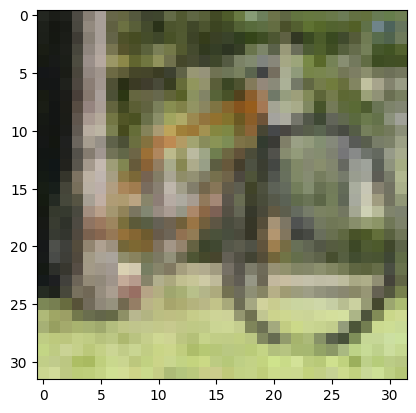

In [ ]:
plt.imshow(data_train[16][0]) # вывод изображения (data_train[16][0] — PIL Image с label 8~bicycle)
# plt.imshow(data_train[16][0].permute(1, 2, 0)) # построение изображения (если его трансформировать)
# .permute(1, 2, 0) меняет местами размерности, на первое место выходит Height, второе — Width, третье — Channels, так как shape(3, 32, 32) ~ (Channels, Height, Width) не воспринимается
# операция схожа с reshape, но permute просто меняет местами индексы, гарантируя, что обращение с соответствующей перестановкой индексов вернёт тот же элемент (что был бы без permute и перестановки индексов)

plt.show() # вывод изображения

## Модель

Предобученная модель взята с: https://huggingface.co/edumunozsala/vit_base-224-in21k-ft-cifar100

In [ ]:
model = ViTForImageClassification.from_pretrained('edumunozsala/vit_base-224-in21k-ft-cifar100') # загружаем предобученную модель с huggingface
torch.save(model.state_dict(), models_path+"model_downloaded_state_dict.pth") # сохраняем её изначальный state_dict в файл model_downloaded.pth, что лежит по пути models_path
torch.save(model, models_path+"model_downloaded.pth") # сохраняем саму модель, потому что ViTForImageClassification требует config для создания

In [ ]:
model = torch.load(models_path+"model_downloaded.pth") # загружаем сохранённую модель
model # вывод строения модели

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

## Обработчик картинок

In [3]:
ViTImageProcessor.preprocess.__defaults__ # стандартные параметры __call__ (preproces) метода у ViTImageProcessor

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 <ChannelDimension.FIRST: 'channels_first'>,
 None)

In [4]:
ViTImageProcessor.preprocess.__defaults__ = (None, None, None, None, None, None, None, None, "pt", ViTImageProcessor.preprocess.__defaults__[9], None) # ставим "pt" на месте параметра return_tensors, чтобы обработчик возвращал pytorch тензоры
ViTImageProcessor.preprocess.__defaults__ # последний None в зависимости от версии transformers

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'pt',
 <ChannelDimension.FIRST: 'channels_first'>,
 None)

In [5]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k') # объект для препроцессинга картинок, с которым обучалась изначальная модель
# torch.save(feature_extractor, models_path+"model_downloaded_feature_extractor.pth") # сохраняем его в файл "model_downloaded_feature_extractor.pth"

In [6]:
feature_extractor = torch.load(models_path+"model_downloaded_feature_extractor.pth") # загружаем препроцессор для картинок
feature_extractor # вывод того, что делает препроцессор

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Пример работы модели

In [ ]:
input_example = feature_extractor(images=data_train[16][0], return_tensors="pt") # предобрабатываем картинку с велосипедом (return_tensors="pt" — возвращаем pytorch тензор)

In [ ]:
input_example # вывод того, во что сконвертировался PIL Image

{'pixel_values': tensor([[[[-0.7255, -0.7255, -0.7255,  ..., -0.1294, -0.1294, -0.1294],
          [-0.7255, -0.7255, -0.7255,  ..., -0.1294, -0.1294, -0.1294],
          [-0.7255, -0.7255, -0.7255,  ..., -0.1294, -0.1294, -0.1294],
          ...,
          [ 0.5922,  0.5922,  0.5922,  ...,  0.4196,  0.4196,  0.4196],
          [ 0.5922,  0.5922,  0.5922,  ...,  0.4196,  0.4196,  0.4196],
          [ 0.5922,  0.5922,  0.5922,  ...,  0.4196,  0.4196,  0.4196]],

         [[-0.7020, -0.7020, -0.7020,  ..., -0.0039, -0.0039, -0.0039],
          [-0.7020, -0.7020, -0.7020,  ..., -0.0039, -0.0039, -0.0039],
          [-0.7020, -0.7020, -0.7020,  ..., -0.0039, -0.0039, -0.0039],
          ...,
          [ 0.6784,  0.6784,  0.6784,  ...,  0.5529,  0.5529,  0.5529],
          [ 0.6784,  0.6784,  0.6784,  ...,  0.5529,  0.5529,  0.5529],
          [ 0.6784,  0.6784,  0.6784,  ...,  0.5529,  0.5529,  0.5529]],

         [[-0.7490, -0.7490, -0.7490,  ..., -0.3490, -0.3490, -0.3490],
          [-0

In [ ]:
input_example["pixel_values"].shape # размерность входа (batch_size, Channels, Height, Width)

torch.Size([1, 3, 224, 224])

In [ ]:
data_train[16][1] # настоящий таргет этого сэмпла

8

In [ ]:
model.eval() # перевод модель в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)
output_example = model(**input_example) # передаём в модель входные данные
output_example # вывод выхода модели (logits - вероятности классов, полученные с помощью logit функции)

ImageClassifierOutput(loss=None, logits=tensor([[-2.2100e-01,  3.6664e-01, -1.7498e-02, -1.9066e-01,  2.5630e-01,
         -1.8679e-01,  4.1031e-02, -1.6793e-01,  9.8878e+00, -2.1973e-01,
          5.4470e-01, -9.1136e-03, -5.4320e-01,  1.1484e-01, -2.8465e-01,
         -3.9441e-01, -2.6831e-01, -9.0195e-02, -6.6151e-03, -7.8942e-02,
         -3.9036e-01, -1.9537e-01,  5.9087e-02,  3.5102e-01, -2.1579e-01,
          4.8623e-02,  1.5578e-01, -1.8561e-01, -7.9289e-02,  3.1258e-01,
         -8.5446e-01,  6.6529e-01, -2.9746e-01, -9.2083e-02,  5.8025e-02,
          1.6811e-01, -3.5605e-01, -2.0179e-01, -6.9506e-02,  6.4792e-01,
         -4.4716e-01, -6.2601e-01, -7.7631e-01, -2.7773e-01, -5.7246e-02,
          4.1897e-01,  3.7924e-01, -6.7312e-01,  1.0508e+00, -7.9381e-02,
         -1.5226e-01, -1.6402e-01,  4.7819e-01, -5.7159e-02, -5.2572e-01,
          1.6712e-01,  8.9945e-02, -3.9202e-01, -2.1837e-01,  1.9421e-01,
          1.4466e-01, -2.1497e-01,  2.5911e-01,  2.7446e-01, -4.5678e-02

In [ ]:
torch.argmax(output_example.logits, axis=-1) # ищём индекс с максимальным значением для каждого батча с помощью axis=-1 (номер самого вероятного класса)
# ответ совпал с таргетом

tensor([8])

## Оценивание текущего качества модели

### Создадим loader для данных с использованием feature_extractor, что совместим с моделью

In [96]:
# датасет для тестирования
data_test = torchvision.datasets.CIFAR100(root=data_path, # путь, откуда брать/куда сохранять датасет
                                          train=False, # какую часть датасета использовать (тестовая)
                                          download=True, # скачивать ли датасет, если его нет в root пути
                                          transform=feature_extractor # функция, принимающая на вход PIL Image и преобразовывающая его
                                         )

# загрузчик данных для тестирования
loader_test = torch.utils.data.DataLoader(dataset=data_test, # указание датасета для DataLoader
                                          batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                          shuffle=True, # перемешивать ли датасет
                                          num_workers=2, # число используемых ядер процессора для ускорения обработки данных
                                          pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                         )

Files already downloaded and verified


In [23]:
def evaluate_model(model, loader, device, finetuned=False) -> np.ndarray:
    """
    Функция для подсчёта матрицы ошибок (confusion matrix).\n
    Parameters:
        * model: оцениваемая модель
        * loader: загрузчик данных для оценивания
        * device: устройство, на котором будет запуск
        * finetuned: ключ, что нужен, если датасет был преобразован из CIFAR-100 формата\n
    Returns:
        * np.ndarray: матрица ошибок (confusion matrix) для классов (строки - true labels, столбцы — predicted labels)
    """
    labels_true = [] # список под настоящие классы
    labels_pred = [] # список под предсказаные классы

    model.to(device) # отправляем модель на девайс
    model.eval() # перевод модели в режим оценивания (dropout перестаёт работать, а BatchNorm собирать статистику)
    with torch.no_grad(): # отключаем подсчёт градиентов
        for batch_idx, (data, target) in enumerate(loader): # идём по батчам, что возвращает loader
            for t in target: # идём по таргетам (их сразу несколько == размер батча в loader)
                labels_true.append(t) # добавляем target в список с настоящими классами (таргеты остаются на cpu)

#======== data preprocessor and model specific code
            if finetuned: # если в loader передан датасет не в виде объекта CIFAR-100
                data["pixel_values"] = data["pixel_values"][:,0].to(device) # dataloader засовывает тензоры в словаре ещё в один список (получая shape [batch_size, 1, Channels, Height, Width]), поэтому просто достаём их из этого списка — пропуская размерность 1 с помощью [:,0] (и отправляем на девайс)
            else: # если в loader передан датасет в виде объекта CIFAR-100
                data["pixel_values"] = data["pixel_values"][0].to(device) # dataloader засовывает тензоры в словаре ещё в один список, поэтому просто достаём их из этого списка (и отправляем на девайс)
            preds = model(**data) # вызываем forward pass модели (предсказываем - preds это список с вероятностями классов)
            preds = torch.argmax(preds.logits, axis=-1) # ищём индекс с максимальным значением для каждого батча с помощью axis=-1 (номер самого вероятного класса)
            preds = preds.to("cpu") # отправляем полученный tensor обратно на cpu, так как confusion_matrix может считаться только на нём
#========
            for pred in preds: # идём по предсказаниям (их сразу несколько == размер батча в loader)
                labels_pred.append(pred) # добавляем предсказанный класс в список с предсказаниями

    confus_matrix = confusion_matrix(y_true=labels_true, y_pred=labels_pred) # считаем матрицу ошибок

    return confus_matrix # возвращаем матрицу ошибок

In [9]:
def print_confusion_matrix(confusion_matrix_full: np.ndarray) -> None:
    """
    Функция для построения матрицы ошибок (confusion matrix) только для интересующих классов. Номера классов: bicycle - 8, motorcycle - 48, background - всё остальное.
    Parameters:
        * confusion_matrix_full: полная матрица ошибок\n
    Returns:
        * None: выводит матрицу ошибок (confusion matrix) для классов (строки - true labels, столбцы — predicted labels)
    """
    confusion_matrix_ = np.zeros(shape=(3,3)) # заготовка под интересующий confusion matrix c классами bicycle, motorcycle, background
    # для bicycle
    confusion_matrix_[0][0] = confusion_matrix_full[8][8] # ячейка [true:bicycle, pred:bicycle]
    confusion_matrix_[0][1] = confusion_matrix_full[8][48] # ячейка [true:bicycle, pred:motorcycle]
    confusion_matrix_[0][2] = confusion_matrix_full[8].sum() - confusion_matrix_[0][0] - confusion_matrix_[0][1] # ячейка [true:bicycle, pred:background] = все (в строке) - уже записанные

    # для motorcycle
    confusion_matrix_[1][0] = confusion_matrix_full[48][8] # ячейка [true:motorcycle, pred:bicycle]
    confusion_matrix_[1][1] = confusion_matrix_full[48][48] # ячейка [true:motorcycle, pred:motorcycle]
    confusion_matrix_[1][2] = confusion_matrix_full[48].sum() - confusion_matrix_[1][0] - confusion_matrix_[1][1] # ячейка [true:motorcycle, pred:background] = все (в строке) - уже записанные

    # для background

    confusion_matrix_[2][0] = confusion_matrix_full.sum(axis=0)[8] - confusion_matrix_[0][0] - confusion_matrix_[1][0] # ячейка [true:background, pred:bicycle] (axis=0 — сумма по столбцам; из всех предсказанных bicycle вычитаем те, что уже в таблице)
    confusion_matrix_[2][1] = confusion_matrix_full.sum(axis=0)[48] - confusion_matrix_[0][1] - confusion_matrix_[1][1] # ячейка [true:background, pred:motorcycle] (axis=0 — сумма по столбцам; из всех предсказанных motorcycle вычитаем те, что уже в таблице)
    confusion_matrix_[2][2] = confusion_matrix_full.sum() - confusion_matrix_.sum() # ячейка [true:background, pred:background] = все (в матрице) - уже записанные

    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ["Bicycle", "Motorcycle", "Background"]).plot() # вывод Confusion Matrix

In [ ]:
confusion_matrix_downloaded_full = evaluate_model(model=model, loader=loader_test, device=device) # считаем confusion matrix для всех классов

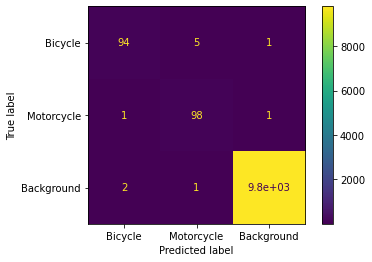

In [ ]:
print_confusion_matrix(confusion_matrix_full=confusion_matrix_downloaded_full) # результаты скаченной модели

* Для класса Bicycle 94 элемента были выявлены правильно, 5 были предсказаны как Motorcycle и 1 как Background.
* Для класса Motorcycle 98 элементов были предсказаны правильно, 1 был предсказан как Bicycle и 1 как Background.
* Для класса Background почти все элементы~10000 были предсказаны "правильно", только 2 были помечены как Bicycle и 1 как Motorcycle.

# 1) Fine-tuning нейронной сети под задачу

In [99]:
def train(model, epochs: np.int64, loader, loss_func, optimizer, num_classes: np.int64, device) -> list: # функция обучения
    """
    Функция обучения модели.\n
    Parameters:
        * model: модель для обучения
        * epochs: число эпох обучения
        * loader: загрузчик данных для обучения
        * loss_func: функция для подсчёта потерь
        * optimizer: оптимайзер для обучения
        * num_classes: число классов в задаче multi-class classification
        * device: устройство, на котором будет запуск\n
    Returns:
        * list: список с получившимися значениями loss функции
    """
    model.to(device) # отправляем модель на девайс
    model.train() # перевод модели в режим обучения (dropout работает, а BatchNorm собирает статистику)

    losses = [0.0] * epochs # заготавливаем массив под значения loss функции
    for epoch in range(epochs): # обучаемся по эпохам
        for batch_idx, (data, target) in enumerate(loader): # идём по батчам, что возвращает loader
            # переводим target в вероятностное пространство (везде нули, кроме нужного таргета - там единица)
            p_true = torch.zeros(size=(loader.batch_size, num_classes), device=device) # заготовка под вероятности (пока заполнена нулями)
            for batch, t in enumerate(target): # идём по батчу (нескольким сэмплам), t - id правильного таргета
                p_true[batch][t] = 1.0 # ставим вероятность 1 у нужных таргетов (для всех элементов в батче)
#================= data preprocessor and model specific code
            data["pixel_values"] = data["pixel_values"][:,0].to(device) # dataloader засовывает тензоры в словаре ещё в один список (получая shape [batch_size, 1, Channels, Height, Width]), поэтому просто достаём их из этого списка — пропуская размерность 1 с помощью [:,0] (и отправляем на девайс)
            p_pred = model(**data) # вызываем forward pass модели (предсказываем - preds это список с вероятностями классов)
            p_pred = p_pred.logits # logits — тензор с вероятностями классов в рассматриваемой модели
#=================

            loss = loss_func(p_pred, p_true) # считаем loss модели
            losses[epoch] += loss/len(loader) # добавляем посчитанный на батче loss (делённый на len(loader) - число батчей, для усреднения)

            optimizer.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
            loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
            optimizer.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)
        print(f"loss on epoch {epoch+1}:\t {losses[epoch]}")
    return losses

Для решения проблемы дисбаланса классов — урежим число элементов в датасете с классом "background" (**Undersampling the majority class**).

### Данные

In [14]:
# датасет для обучения
data_train = torchvision.datasets.CIFAR100(root=data_path, # путь, откуда брать/куда сохранять датасет
                                           train=True, # какую часть датасета использовать (обучающая)
                                           download=True, # скачивать ли датасет, если его нет в root пути
                                           transform=feature_extractor # функция, принимающая на вход PIL Image и преобразовывающая его
                                          )

Files already downloaded and verified


In [15]:
samples_with_background = [] # индексы элементов с классом background () (их будет ~ 40000)
samples_with_bicycle_and_motorcycle = [] # индексы элементов с классом bicycle или motorcycle (их будет равное количество ~ 500 каждого)
for i, sample in tqdm(enumerate(data_train)): # идём по всем сэмплам
    if sample[1] == 8 or sample[1] == 48: # если они из интересующих нас классов
        samples_with_bicycle_and_motorcycle.append(i) # записываем номер сэмпла в список с классами bicycle и motorcycle
    else: # если же их класс нас не сильно интересует
        samples_with_background.append(i) # записываем в список с background

50000it [08:00, 104.04it/s]


In [20]:
data_train_ = [] # заготавливаем пустой список под датасет (будет по 500 сэмплов для каждого из трёх классов - bicycle, motorcycle, background)

for i in samples_with_bicycle_and_motorcycle: # идём по индексам данных с интересующими классами
    data_train_.append(data_train[i]) # копируем их (все) в "новый" датасет

for i in random.sample(samples_with_background, 500): # случайным образом выбираем индексы элементов класса "background", что будут использованы для обучения (выбираем 500, чтобы в итоге пропорции классов были одинаковыми)
    data_train_.append(data_train[i]) # добавляем элементы класса "background" в обучающий датасет

data_train = data_train_ # заменяем полный датасет на урезанный, но сбалансированный

In [24]:
# конвертация таргетов
for i, (data, target) in enumerate(data_train): # идём по элементам в датасете
    if target == 8: # bicycle из 8-го таргета становится 0-м
        data_train[i] = (data_train[i][0], 0)
    elif target == 48: # motorcycle из 48-го таргета становится 1-м
        data_train[i] = (data_train[i][0], 1)
    else: # всё остальное становится 2-м
        data_train[i] = (data_train[i][0], 2)

In [28]:
# with open(data_path+"data_train_processed.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#     pickle.dump(data_train, f) # сохранение обработанного обучающего датасета

In [100]:
with open(data_path+"data_train_processed.pkl", 'rb') as f:
    data_train = pickle.load(f)

In [101]:
# загрузчик данных для обучения
loader_train = torch.utils.data.DataLoader(dataset=data_train, # указание датасета для DataLoader
                                           batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                           shuffle=True, # перемешивать ли датасет
                                           num_workers=2, # число используемых ядер процессора для ускорения обработки данных
                                           pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                           )

### Модель

In [102]:
model = torch.load(models_path+"model_downloaded.pth") # загружаем сохранённую модель

In [103]:
model.classifier = torch.nn.Linear(in_features=768, out_features=3, bias=True) # меняем голову модели под задачу

In [104]:
model # вывод нового строения модели

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Loss function

In [17]:
# Как вариант (неудачный) решения проблемы дисбаланса классов — увеличим вес нужных классов при подсчёте loss функции, чтобы ошибка в них сильнее отзывалась в модели. Например — увеличим их вес в 5 раз по отношению к классу "Background".
# loss_weights = torch.ones(size=(3,), device=device, dtype=dtype) # вектор с весами для
# loss_weights[0] = 20.0
# loss_weights[1] = 20.0
# loss_weights

In [105]:
# loss_function = torch.nn.CrossEntropyLoss(weight=loss_weights, reduction='sum') # создаём функцию для подсчёта loss с указанием "особых" весов классов (reduction='mean' — усреднение loss по классам с учётом весов)
loss_function = torch.nn.CrossEntropyLoss(reduction='mean') # создаём функцию для подсчёта loss с указанием "особых" весов классов (reduction='mean' — усреднение loss по классам с учётом весов)
# loss - кросс-энтропия (перекрёстная энтропия)
# CrossEntropyLoss на вход ожидает вероятность класса для всех k классов
# то есть массив с вероятностями для каждой из четырёх категорий новостей

### Optimizer

In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор для обучения

### Training

In [107]:
losses = train(model=model, # передаём модель в обучение
               epochs=epochs, # передаём число эпох обучения
               loader=loader_train, # передаём загрузчик данных
               loss_func=loss_function, # передаём функция для подсчёта ошибки
               optimizer=optimizer, # передаём оптимизатор обучения
               num_classes=num_classes, # передаём число классов
               device=device # передаём, на каком устройстве будет выполнение
              )

loss on epoch 1:	 0.22003088891506195
loss on epoch 2:	 0.060158055275678635
loss on epoch 3:	 0.0562443807721138
loss on epoch 4:	 0.017192140221595764
loss on epoch 5:	 0.012705035507678986


In [109]:
for i in range(epochs): # идём по числу эпох
    losses[i] = losses[i].detach().to("cpu") # возвращаем loss на cpu и убираем requires grad

# сохранение посчитанного loss
with open(loss_path+"loss_finetuned.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
    pickle.dump(losses, f) # сохранение значения loss

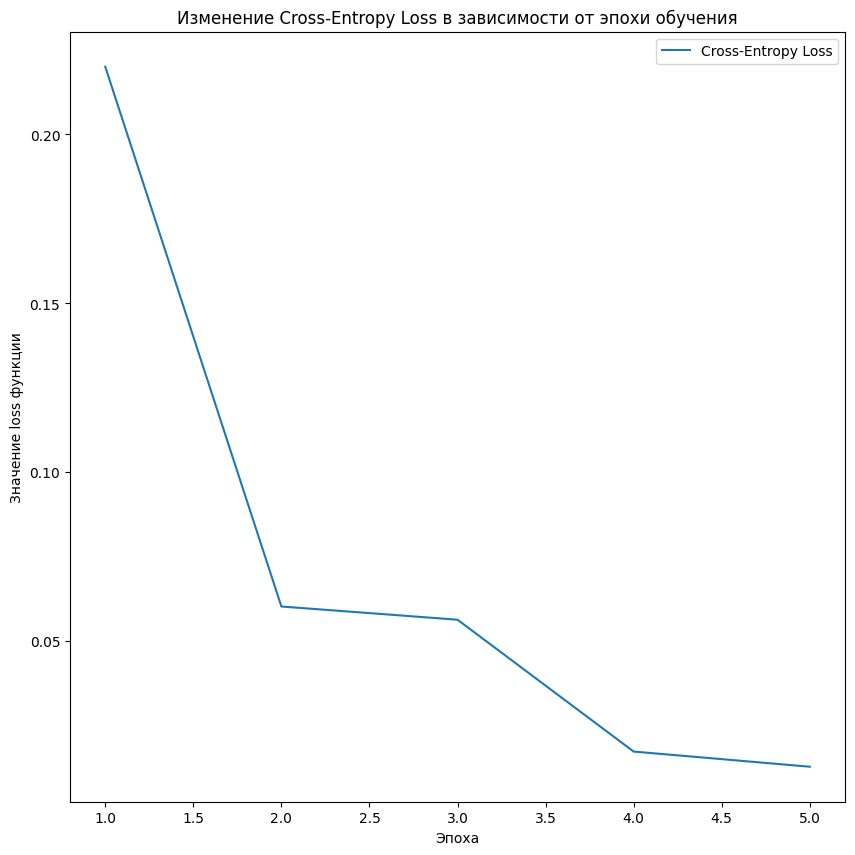

In [110]:
plt.figure(figsize=(10,10)) # размер графика
plt.title("Изменение Cross-Entropy Loss в зависимости от эпохи обучения") # название графика
plt.plot(range(1, epochs+1), losses, label="Cross-Entropy Loss") # построение графика, где range(1, epochs+1) — рассматриваемые значения x, losses — отображаемые значения, label — названия графика
plt.xlabel("Эпоха") # подпись по оси x
plt.ylabel("Значение loss функции") # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

**Модель обучилась, сохраним!**

In [111]:
model.to("cpu") # возвращаем модель на cpu
# torch.save(model.state_dict(), models_path+"model_finetuned_state_dict.pth") # сохраняем state_dict обученной модели в файл model_finetuned_state_dict.pth, что лежит по пути models_path
# torch.save(model, models_path+"model_finetuned.pth") # сохраняем саму модель, потому что ViTForImageClassification требует config для создания

# 2) Анализ результатов

### Пересоздадим датасет и loader для теста с использованием только трёх таргетов

In [7]:
# датасет для тестирования
data_test = torchvision.datasets.CIFAR100(root=data_path, # путь, откуда брать/куда сохранять датасет
                                          train=False, # какую часть датасета использовать (тестовая)
                                          download=True, # скачивать ли датасет, если его нет в root пути
                                          transform=feature_extractor # функция, принимающая на вход PIL Image и преобразовывающая его
                                         )

Files already downloaded and verified


In [8]:
data_test_ = [] # заготавливаем пустой список под датасет

for i, (data, target) in tqdm(enumerate(data_test)):
    if target == 8: # bicycle из 8-го таргета становится 0-м
        data_test_.append((data_test[i][0], 0))
    elif target == 48: # motorcycle из 48-го таргета становится 1-м
        data_test_.append((data_test[i][0], 1))
    else: # всё остальное становится 2-м
        data_test_.append((data_test[i][0], 2))

data_test = data_test_ # заменяем полный датасет на урезанный, но сбалансированный

10000it [05:31, 30.20it/s]


In [9]:
# with open(data_path+"data_test_processed.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#     pickle.dump(data_test, f) # сохранение обработанного обучающего датасета

In [10]:
with open(data_path+"data_test_processed.pkl", 'rb') as f:
    data_test = pickle.load(f)

In [11]:
# загрузчик данных для тестирования
loader_test = torch.utils.data.DataLoader(dataset=data_test, # указание датасета для DataLoader
                                          batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                          shuffle=True, # перемешивать ли датасет
                                          num_workers=2, # число используемых ядер процессора для ускорения обработки данных
                                          pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                         )

### Оцениваем дообученную модель

In [13]:
model = torch.load(models_path+"model_finetuned.pth") # загружаем сохранённую модель

In [24]:
confusion_matrix_finetuned = evaluate_model(model=model, loader=loader_test, device=device, finetuned=True) # считаем confusion matrix для трёх классов на fine-tuned модели

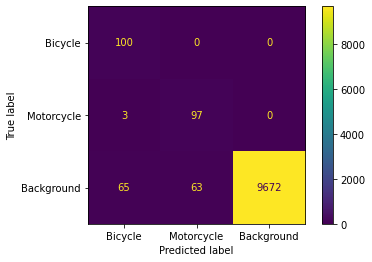

In [25]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_finetuned, display_labels=["Bicycle", "Motorcycle", "Background"]).plot() # вывод Confusion Matrix

* Модель угадала все Bicycle!
* Motorcycle был спутан лишь трижды с классом Bicycle.
* Background в основной своей массе был предсказан правильно, на совпадение с классами Bicycle и Motorcycle может свидетельствовать малое количество объектов в обучающей выборке (не покрывающее все возможные классы изначального датасета) и небольшое переобучение, из-за которого модель старалась угадать Bicycle или Motorcycle.

# 3) Сравнение производительности

# 4) Манипуляция с весами